In [2]:
#hide
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

# From Model to Production

In [11]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.widgets import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Searching for 'sky lupine'


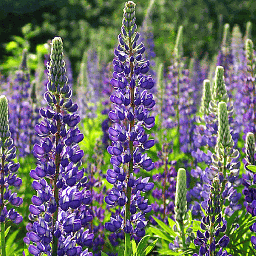

In [10]:
urls = search_images('sky lupine', max_images=1)

dest = 'flower.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'california poppy'


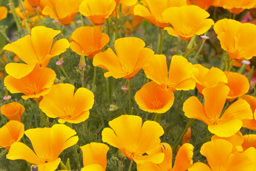

In [116]:
urls = search_images('california poppy', max_images=1)

dest = 'poppy.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'lupines and poppy'


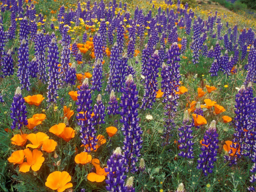

In [117]:
urls = search_images('lupines and poppy', max_images=1)

dest = 'mix.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

In [19]:
searches = 'sky lupine','douglas iris', "california poppy", "california fuchsia"
path = Path('wildflowers')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}', max_images=150))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'sky lupine'
Searching for 'douglas iris'
Searching for 'california poppy'
Searching for 'california fuchsia'


We've successfully downloaded the URLs of 150 of each wildflower (or, at least, images that DuckDuckGo Image Search finds for that search term).

**NB**: there's no way to be sure exactly what images a search like this will find. 

Our folder has image files, as we'd expect:

In [20]:
fns = get_image_files(path)
fns

(#344) [Path('wildflowers/california fuchsia/c4922b6e-2ce7-4c5b-8dce-d894efdf7f86.jpg'),Path('wildflowers/california fuchsia/c50ff693-e801-4575-8312-6fda6d0be6e3.jpg'),Path('wildflowers/california fuchsia/438276e4-01cf-4c4f-b847-2d8663d80e50.jpg'),Path('wildflowers/california fuchsia/b33066b8-33fd-4227-95d4-b37b2eddb538.jpg'),Path('wildflowers/california fuchsia/a96c403d-e071-4da8-986f-87fcfab63ca4.jpg'),Path('wildflowers/california fuchsia/a364a0e0-bdde-44d4-a360-1a3eaab69c41.jpg'),Path('wildflowers/california fuchsia/2236dd26-73ec-4411-8537-cd1224b7afb7.jpg'),Path('wildflowers/california fuchsia/7cb103f7-e6cc-4c92-9ebb-5dd709c5a3ba.jpg'),Path('wildflowers/california fuchsia/a9ce9dd5-1de7-4228-87d0-8b9a7ec8bf61.jpg'),Path('wildflowers/california fuchsia/ac600bd3-6d2e-45bc-99ae-ac2eebcd9e4f.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [22]:
failed = verify_images(fns)
failed

(#5) [Path('wildflowers/sky lupine/db662da5-f197-44ea-9043-e4074f644c61.jpg'),Path('wildflowers/sky lupine/19c38539-d23e-4bd6-b362-0341313029c2.jpg'),Path('wildflowers/sky lupine/4aaef8c8-35f6-4080-98b0-01937b4fb276.jpg'),Path('wildflowers/california poppy/a4c663a0-9b27-4b60-890f-566032bb1466.jpeg'),Path('wildflowers/douglas iris/db3fe0f1-73c6-4bc0-a36b-9f0447dafa14.jpg')]

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [23]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [24]:
flowers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [26]:
dls = flowers.dataloaders(path)

A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

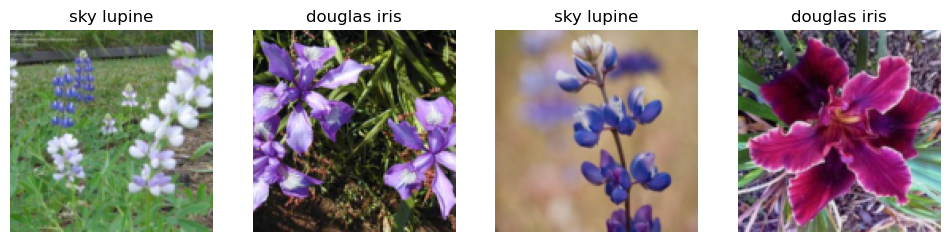

In [27]:
dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

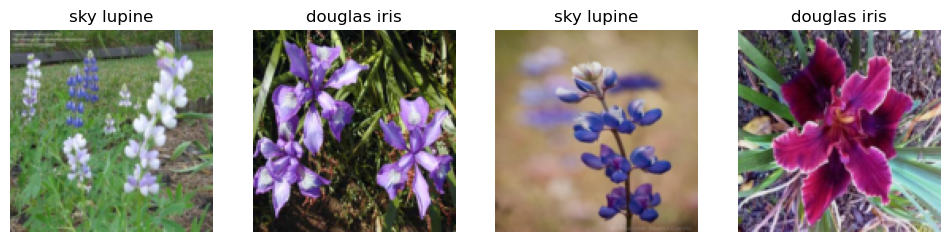

In [29]:
flowers = flowers.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = flowers.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

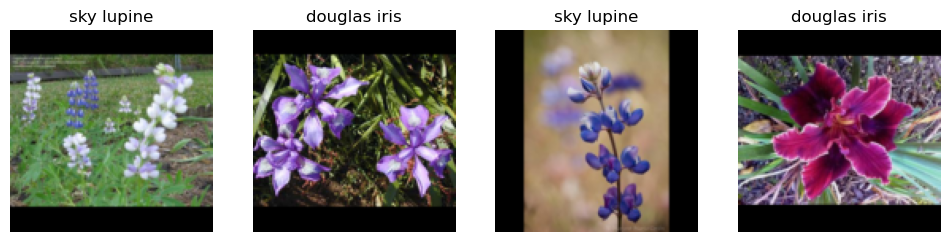

In [30]:
flowers = flowers.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = flowers.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace `Resize` with `RandomResizedCrop`, which is the transform that provides the behavior we just described. The most important parameter to pass in is `min_scale`, which determines how much of the image to select at minimum each time:

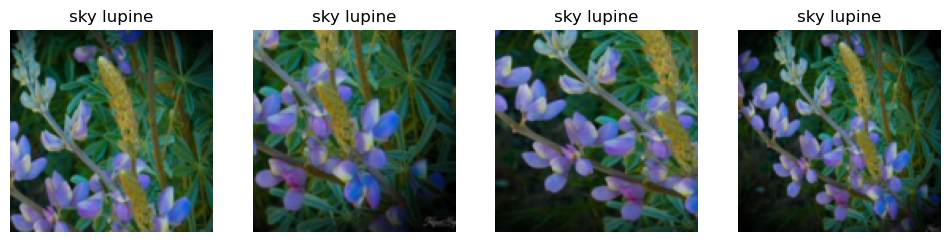

In [31]:
flowers = flowers.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = flowers.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

We used `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

### Data Augmentation

*Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter (note that we're not using `RandomResizedCrop` in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

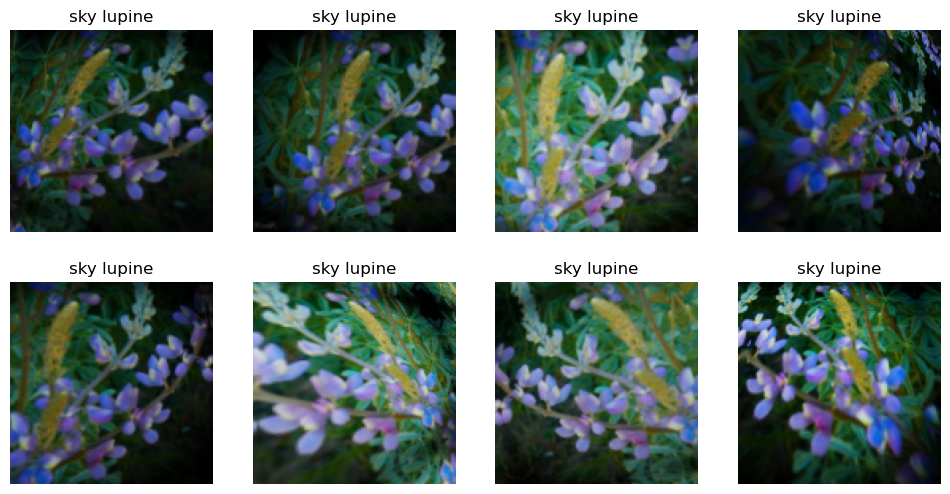

In [32]:
flowers = flowers.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = flowers.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training Your Model, and Using It to Clean Your Data

We don't have a lot of data for our problem (150 pictures of each sort of flower at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [34]:
flowers = flowers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = flowers.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [36]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.989606,0.684162,0.298507,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.867408,0.447059,0.089552,00:49
1,0.619912,0.320071,0.044776,00:49
2,0.470967,0.334325,0.029851,00:49


Now let's see what mistakes the model is making. To visualize this, we can create a *confusion matrix*:

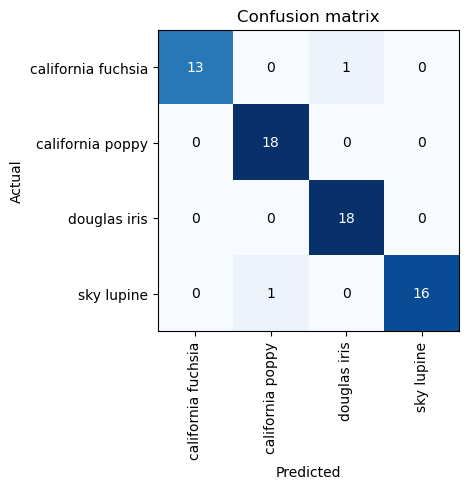

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't flowers at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

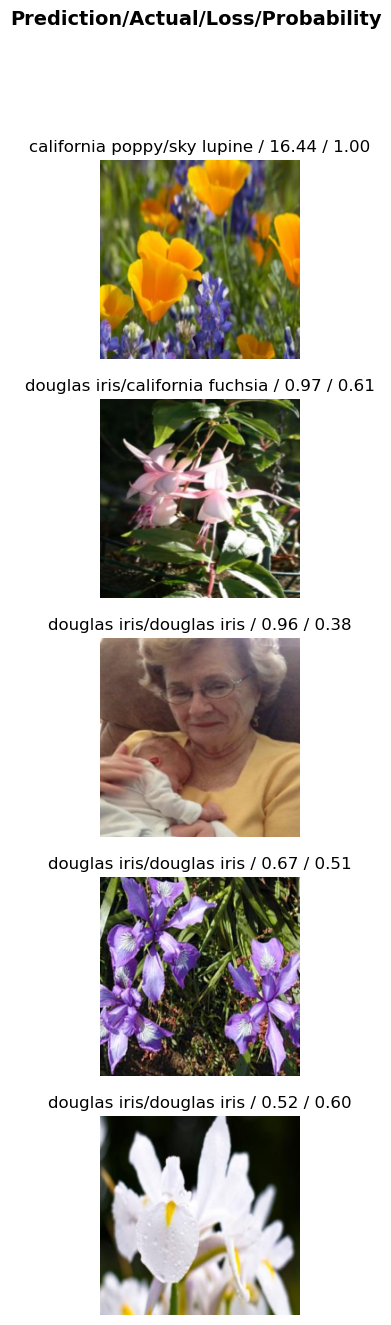

In [41]:
interp.plot_top_losses(5, nrows=5)

Clearly some of these images do not match the labels.

The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [74]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [92]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

We can see some wrong classifications. So, we should choose `<Delete>` in the menu under this image. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (`unlink`) all images selected for deletion, we would run:

```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images for which we've selected a different category, we would run:

```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

> s: Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

We'll be seeing more examples of model-driven data cleaning throughout this book. Once we've cleaned up our data, we can retrain our model. Try it yourself, and see if your accuracy improves!

In [95]:
flowers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

flowers = flowers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = flowers.dataloaders(path)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.040518,0.847285,0.353846,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.928615,0.300142,0.107692,00:51
1,0.679968,0.123891,0.046154,00:52
2,0.542222,0.116801,0.015385,00:52


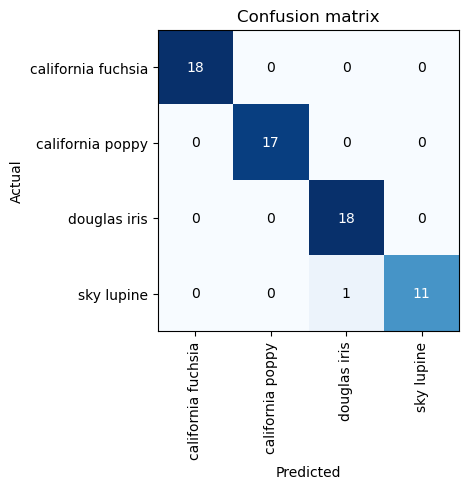

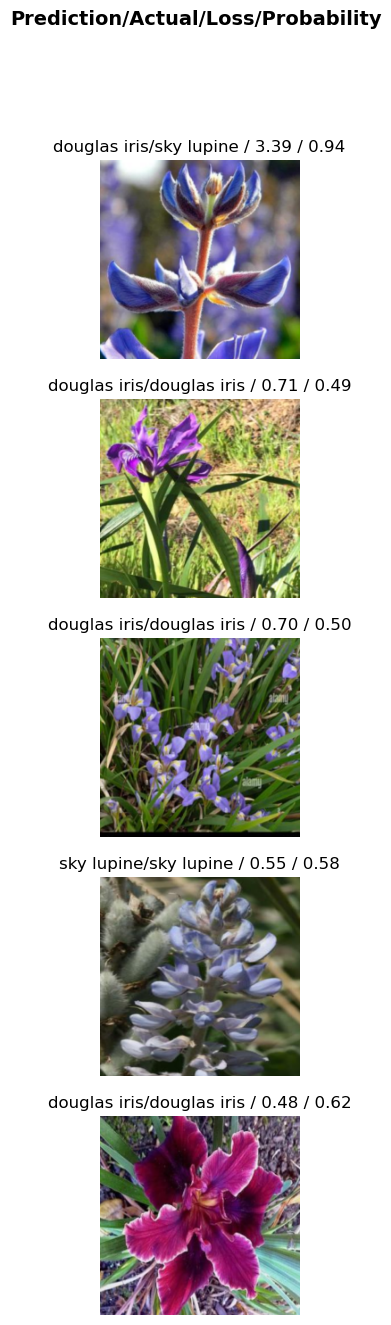

In [96]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=5)

## Turning Your Model into an Online Application

We are now going to look at what it takes to turn this model into a working online application. We will just go as far as creating a basic working prototype; we do not have the scope in this book to teach you all the details of web application development generally.

### Using the Model for Inference

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [100]:
learn.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [101]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('export.pkl'),Path('export1.pkl')]

You'll need this file wherever you deploy your app to.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [104]:
learn_inf = load_learner(path/'export.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [106]:
learn_inf.predict('flower.jpg')

('sky lupine',
 tensor(3),
 tensor([2.3114e-03, 3.5958e-03, 8.0150e-05, 9.9401e-01]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [107]:
learn_inf.dls.vocab

['california fuchsia', 'california poppy', 'douglas iris', 'sky lupine']

We can see here that if we index into the vocab with the integer returned by `predict` then we get back "grizzly," as expected. Also, note that if we index into the list of probabilities, we see a nearly 1.00 probability that this is a grizzly.

We know how to make predictions from our saved model, so we have everything we need to start building our app.

### Creating an App from the Model Using Gradio

In [111]:
!pip install -q gradio

First, we define a prediction function to do what we did above.

In [109]:
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

Finally, let's import Gradio and use it's functionality to make an interface and launch it.

In [119]:
import gradio as gr

title = "Identify Wildflowers!"
description = "A wildflower image classifier trained on publically available images with fastai and ResNet-18."
examples = ['flower.jpg', 'poppy.jpg', 'mix.jpg']
interpretation='default'
enable_queue=True
gr.Interface(fn=predict,inputs=gr.inputs.Image(shape=(512, 512)),outputs=gr.outputs.Label(num_top_classes=3),title=title,description=description,examples=examples,interpretation=interpretation,enable_queue=enable_queue).launch(share=True)

/tmp/ipykernel_32/1351895302.py:8: UserWarning: `enable_queue` is deprecated in `Interface()`, please use it within `launch()` instead.
  gr.Interface(fn=predict,inputs=gr.inputs.Image(shape=(512, 512)),outputs=gr.outputs.Label(num_top_classes=3),title=title,description=description,examples=examples,interpretation=interpretation,enable_queue=enable_queue).launch(share=True)


Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://e9bd7d4980527bef8d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
